In [1]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RepeatedKFold

from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()

import warnings 
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

# DATASET

## Nonspeech7k

In [2]:
### Features for Nonspeech7k

# Data with GEMAPS features:
nonspeech_gemaps_file = pd.read_csv('/Users/anastasiiapovolotskaia/Desktop/research_on_features/признаки_Nonspeech7k/Nonspeech7k features/Nonspeech_gemaps.csv')
nonspeech_gemaps_dataset = nonspeech_gemaps_file.to_numpy()

# Data with eGEMAPS features:
nonspeech_egemaps_file = pd.read_csv('/Users/anastasiiapovolotskaia/Desktop/research_on_features/признаки_Nonspeech7k/Nonspeech7k features/Nonspeech7k_egemaps.csv')
nonspeech_egemaps_dataset = nonspeech_egemaps_file.to_numpy()

# Data with Interspeech 2009 features:
nonspeech_is09_file = pd.read_csv('/Users/anastasiiapovolotskaia/Desktop/research_on_features/признаки_Nonspeech7k/Nonspeech7k features/Nonspeech_IS09.csv')
nonspeech_is09_dataset = nonspeech_is09_file.to_numpy()

# Data with Interspeech 2010 features:
nonspeech_is10_file = pd.read_csv('/Users/anastasiiapovolotskaia/Desktop/research_on_features/признаки_Nonspeech7k/Nonspeech7k features/Nonspeech_IS10.csv')
nonspeech_is10_dataset = nonspeech_is10_file.to_numpy()

# Data with Interspeech 2013 features:
nonspeech_is13_file = pd.read_csv('/Users/anastasiiapovolotskaia/Desktop/research_on_features/признаки_Nonspeech7k/Nonspeech7k features/Nonspeech_IS13.csv')
nonspeech_is13_dataset = nonspeech_is13_file.to_numpy()

# target values:
nonspeech_targets = np.loadtxt('/Users/anastasiiapovolotskaia/Desktop/research_on_features/признаки_Nonspeech7k/Nonspeech7k features/target_values.csv')

In [3]:
### Classes in the Nonspeech7k dataset
NS_classes = {'0': 'breath/дыхание',
              '1': 'cough/кашель  ',
              '2': 'cry/плач      ',
              '3': 'laugh/смех    ',
              '4': 'scream/крик   ',
              '5': 'sneeze/чихание',
              '6': 'yawn/зевание  '}

### Nonspeech7k Scores
scores_NS = {'recall0': make_scorer(recall_score, average = None, labels = [0]), 
            'recall1': make_scorer(recall_score, average = None, labels = [1]),
            'recall2': make_scorer(recall_score, average = None, labels = [2]),
            'recall3': make_scorer(recall_score, average = None, labels = [3]),
            'recall4': make_scorer(recall_score, average = None, labels = [4]),
            'recall5': make_scorer(recall_score, average = None, labels = [5]),
            'recall6': make_scorer(recall_score, average = None, labels = [6]),
            
            'precision0': make_scorer(precision_score, average = None, labels = [0]), 
            'precision1': make_scorer(precision_score, average = None, labels = [1]),
            'precision2': make_scorer(precision_score, average = None, labels = [2]),
            'precision3': make_scorer(precision_score, average = None, labels = [3]),
            'precision4': make_scorer(precision_score, average = None, labels = [4]),
            'precision5': make_scorer(precision_score, average = None, labels = [5]),
            'precision6': make_scorer(precision_score, average = None, labels = [6]),
            
            'accuracy' : 'accuracy'}

# Functions

In [4]:
# def to count Confidence Intervals

significance_level = 0.05 
def ci(metric_list):
    """_summary_
    Args:
        metric_list (): list of classification results from cross-validation
    Returns:
        string: result for a class ± confidence interval
    """
    mean_metric = np.array(metric_list).mean(axis=0)
    a = 1.0 * np.array(metric_list)
    n = len(a)
    degrees_of_freedom = n - 1
    se = sp.stats.sem(metric_list)
    
    t_value = sp.stats.t.ppf(1 - significance_level/2., degrees_of_freedom)
    h = t_value * se
    
    return f'{"{:.3f}".format(mean_metric)} ± {"{:.3f}".format(h)}'

In [6]:
# def to plot the result of PCA

def plot_relation_between_VAR_and_DIM(x_train_scaler):
    """
    Function to use PCA (dimensionality reduction) and plot the relation between the Variance and the Dimensions
    : param x_train_scaler - dataset that is used for training
    """
    pca = PCA()
    pca.fit(x_train_scaler)
    cumsum = np.cumsum(pca.explained_variance_ratio_)*100
    d = [n for n in range(len(cumsum))]
    plt.figure(figsize=(5, 5))
    plt.plot(d,cumsum, color = 'red',label='cumulative explained variance')
    plt.title('Cumulative Explained Variance as a Function of the Number of Components')
    plt.ylabel('Cumulative Explained variance')
    plt.xlabel('Principal components')
    plt.axhline(y = 95, color='k', linestyle='--', label = '95% Explained Variance')
    plt.legend(loc='best')

In [12]:
# def to apply pca and transform to data
# the min Variance is set to 95%, therefore the the minimum dimentions are chosen keeping the stated Variance

def pca_transform(train_scaler):
    pca = PCA(.95) 
    pca.fit(train_scaler)
    train_pca = pca.transform(train_scaler)
    return train_pca

In [7]:
# def to get results using 5x2 cross-validation in the Nonspeech7k

def cv_for_nonspeech7k(models_list, names_list, dataset, targets, dict_classes=NS_classes, scores_list=scores_NS):
    """_summary_

    Args:
        models_list (list): list of ML-models with hyperparameters
        names_list (list): names enumerated in this list
        dataset (numpy.ndarray): dataset to be used for Cross-Validation
        targets (numpy.ndarray): targets for the dataset
        dict_classes (dict): Classes to classify. Defaults to NS_classes.
        scores_list (dict): Scores to count. Defaults to scores_NS.
    """
    cv = RepeatedKFold(n_splits=2, n_repeats=5, random_state=1)
    
    for model, name in zip(models_list, names_list):
        
        cv_results = cross_validate(model, dataset, targets, cv=cv, scoring=scores_list)
        
        print(f'{name}:')
        print('---------------------------------------------------')
        print('|  Class         | Recall         | Precision     |')
        print('---------------------------------------------------')
        
        recall_scores_common = 0
        recall_h_common = 0
        precision_scores_common = 0
        precision_h_common = 0
        
        for el1, el2 in zip(list(cv_results)[2:9], list(cv_results)[9:16]):
            result_recall = f'{el1}: {ci(cv_results[el1])}'
            recall_scores_common += np.mean(cv_results[el1])
            recall_h_common += float(result_recall[-5:])
            index = result_recall[11]
            result_precision = f'{el2}: {ci(cv_results[el2])}'
            precision_scores_common += np.mean(cv_results[el2])
            precision_h_common += float(result_precision[-5:])    
            print(f'| {dict_classes[index]} | {result_recall[13:]} | {result_precision[17:]} |')
        
        average_recall = "{:.3f}".format(recall_scores_common / 7)
        average_h_recall = "{:.3f}".format(recall_h_common / 7)
        average_precision = "{:.3f}".format(precision_scores_common / 7)
        average_h_precision = "{:.3f}".format(precision_h_common / 7)
        
        print('---------------------------------------------------')
        print(f'Average Scores   |  {average_recall} ± {average_h_recall} | {average_precision} ± {average_h_precision} |')
        print('---------------------------------------------------')
        accuracy_list = list(cv_results['test_accuracy'])
        print(f'Accuracy Score: {ci(accuracy_list)}                     |')
        print('---------------------------------------------------')
        print()

# ML Algorithms and Neural Network

In [8]:
# The list of the used models 

models_NS = [SVC(kernel='poly'), 
             SVC(kernel='rbf'), 
             SVC(kernel='sigmoid'), 
             LDA(), 
             KNeighborsClassifier(n_neighbors=7), 
             LogisticRegression(), 
             DecisionTreeClassifier(), 
             MLPClassifier(hidden_layer_sizes=(256, 256, 256), validation_fraction=0.5, verbose=False, random_state=1)]
             

names_NS = ['SVM_Poly', 'SVM_RBF', 'SVM_Sigmoid', 'LDA', 'KNN', 'Logistic Regression', 'Decision Tree', 'Neural Network']

# Classification results based on PCA 

### Nonspeech7k - GEMAPS Features

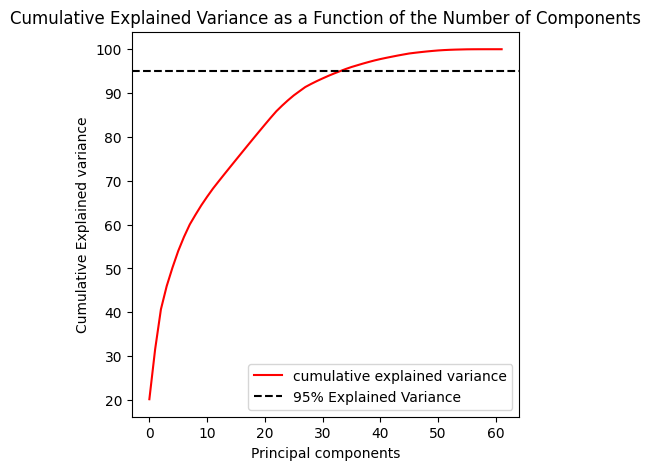

In [13]:
scaler.fit(nonspeech_gemaps_dataset)
nonspeech_gemaps_scaler = scaler.transform(nonspeech_gemaps_dataset)

plot_relation_between_VAR_and_DIM(nonspeech_gemaps_scaler)

nonspeech_gemaps_pca = pca_transform(nonspeech_gemaps_scaler)

In [14]:
cv_for_nonspeech7k(models_NS, names_NS, nonspeech_gemaps_pca, nonspeech_targets)

SVM_Poly:
---------------------------------------------------
|  Class         | Recall         | Precision     |
---------------------------------------------------
| breath/дыхание |  0.937 ± 0.005 | 0.934 ± 0.004 |
| cough/кашель   |  0.238 ± 0.018 | 0.617 ± 0.016 |
| cry/плач       |  0.924 ± 0.005 | 0.539 ± 0.020 |
| laugh/смех     |  0.492 ± 0.044 | 0.643 ± 0.025 |
| scream/крик    |  0.494 ± 0.029 | 0.879 ± 0.020 |
| sneeze/чихание |  0.105 ± 0.015 | 0.508 ± 0.045 |
| yawn/зевание   |  0.151 ± 0.017 | 0.735 ± 0.082 |
---------------------------------------------------
Average Scores   |  0.477 ± 0.019 | 0.693 ± 0.030 |
---------------------------------------------------
Accuracy Score: 0.679 ± 0.009                     |
---------------------------------------------------

SVM_RBF:
---------------------------------------------------
|  Class         | Recall         | Precision     |
---------------------------------------------------
| breath/дыхание |  0.971 ± 0.002 | 0.911 ± 

### Nonspeech7k - eGEMAPS Features

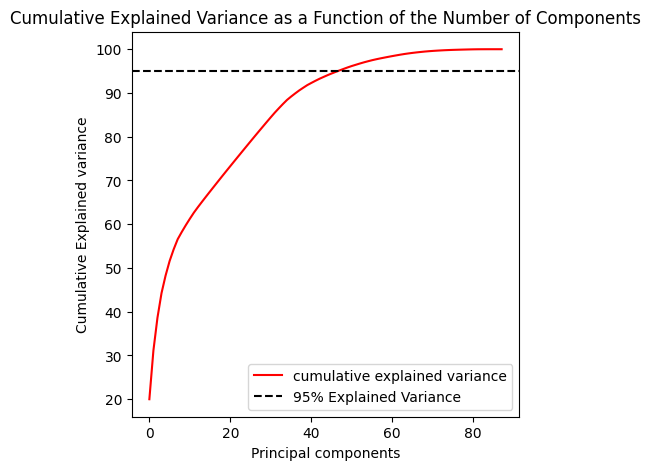

In [15]:
scaler.fit(nonspeech_egemaps_dataset)
nonspeech_egemaps_scaler = scaler.transform(nonspeech_egemaps_dataset)

plot_relation_between_VAR_and_DIM(nonspeech_egemaps_scaler)

nonspeech_egemaps_pca = pca_transform(nonspeech_egemaps_scaler)

In [16]:
cv_for_nonspeech7k(models_NS, names_NS, nonspeech_egemaps_pca, nonspeech_targets)

SVM_Poly:
---------------------------------------------------
|  Class         | Recall         | Precision     |
---------------------------------------------------
| breath/дыхание |  0.930 ± 0.004 | 0.940 ± 0.004 |
| cough/кашель   |  0.194 ± 0.012 | 0.615 ± 0.027 |
| cry/плач       |  0.922 ± 0.008 | 0.546 ± 0.025 |
| laugh/смех     |  0.508 ± 0.060 | 0.599 ± 0.030 |
| scream/крик    |  0.521 ± 0.022 | 0.880 ± 0.022 |
| sneeze/чихание |  0.114 ± 0.014 | 0.512 ± 0.031 |
| yawn/зевание   |  0.123 ± 0.014 | 0.765 ± 0.061 |
---------------------------------------------------
Average Scores   |  0.473 ± 0.019 | 0.694 ± 0.029 |
---------------------------------------------------
Accuracy Score: 0.677 ± 0.009                     |
---------------------------------------------------

SVM_RBF:
---------------------------------------------------
|  Class         | Recall         | Precision     |
---------------------------------------------------
| breath/дыхание |  0.974 ± 0.003 | 0.918 ± 

### Nonspeech7k - Interspeech 2009 Features

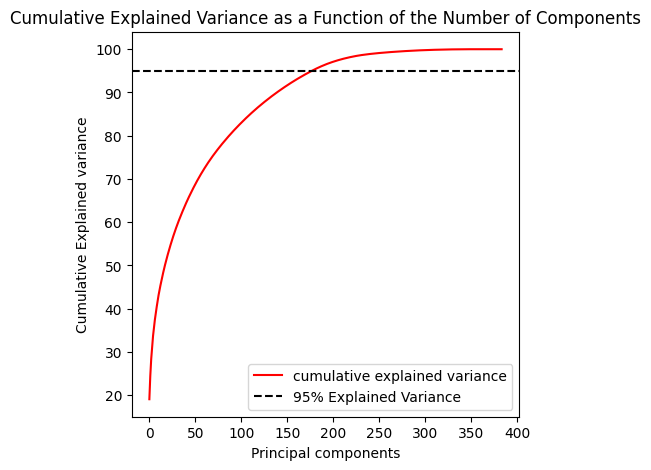

In [17]:
scaler.fit(nonspeech_is09_dataset)
nonspeech_IS09_scaler = scaler.transform(nonspeech_is09_dataset)

plot_relation_between_VAR_and_DIM(nonspeech_IS09_scaler)

nonspeech_IS09_pca = pca_transform(nonspeech_IS09_scaler)

In [18]:
cv_for_nonspeech7k(models_NS, names_NS, nonspeech_IS09_pca, nonspeech_targets)

SVM_Poly:
---------------------------------------------------
|  Class         | Recall         | Precision     |
---------------------------------------------------
| breath/дыхание |  0.909 ± 0.005 | 0.942 ± 0.003 |
| cough/кашель   |  0.209 ± 0.019 | 0.698 ± 0.019 |
| cry/плач       |  0.946 ± 0.008 | 0.514 ± 0.011 |
| laugh/смех     |  0.432 ± 0.032 | 0.692 ± 0.033 |
| scream/крик    |  0.490 ± 0.030 | 0.932 ± 0.014 |
| sneeze/чихание |  0.340 ± 0.030 | 0.766 ± 0.043 |
| yawn/зевание   |  0.265 ± 0.018 | 0.865 ± 0.053 |
---------------------------------------------------
Average Scores   |  0.513 ± 0.020 | 0.773 ± 0.025 |
---------------------------------------------------
Accuracy Score: 0.677 ± 0.004                     |
---------------------------------------------------

SVM_RBF:
---------------------------------------------------
|  Class         | Recall         | Precision     |
---------------------------------------------------
| breath/дыхание |  0.962 ± 0.002 | 0.916 ± 

### Nonspeech7k - Interspeech 2010 Features

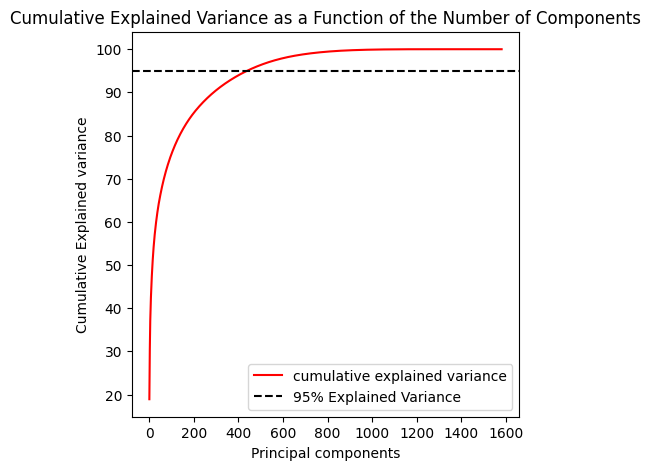

In [19]:
scaler.fit(nonspeech_is10_dataset)
nonspeech_IS10_scaler = scaler.transform(nonspeech_is10_dataset)

plot_relation_between_VAR_and_DIM(nonspeech_IS10_scaler)

nonspeech_IS10_pca = pca_transform(nonspeech_IS10_scaler)

In [20]:
cv_for_nonspeech7k(models_NS, names_NS, nonspeech_IS10_pca, nonspeech_targets)

SVM_Poly:
---------------------------------------------------
|  Class         | Recall         | Precision     |
---------------------------------------------------
| breath/дыхание |  0.921 ± 0.003 | 0.961 ± 0.002 |
| cough/кашель   |  0.452 ± 0.018 | 0.800 ± 0.021 |
| cry/плач       |  0.942 ± 0.006 | 0.594 ± 0.020 |
| laugh/смех     |  0.581 ± 0.050 | 0.792 ± 0.033 |
| scream/крик    |  0.703 ± 0.021 | 0.918 ± 0.009 |
| sneeze/чихание |  0.331 ± 0.018 | 0.710 ± 0.022 |
| yawn/зевание   |  0.331 ± 0.021 | 0.833 ± 0.051 |
---------------------------------------------------
Average Scores   |  0.609 ± 0.020 | 0.801 ± 0.023 |
---------------------------------------------------
Accuracy Score: 0.753 ± 0.007                     |
---------------------------------------------------

SVM_RBF:
---------------------------------------------------
|  Class         | Recall         | Precision     |
---------------------------------------------------
| breath/дыхание |  0.969 ± 0.004 | 0.944 ± 

### Nonspeech7k - Interspeech 2013 Features

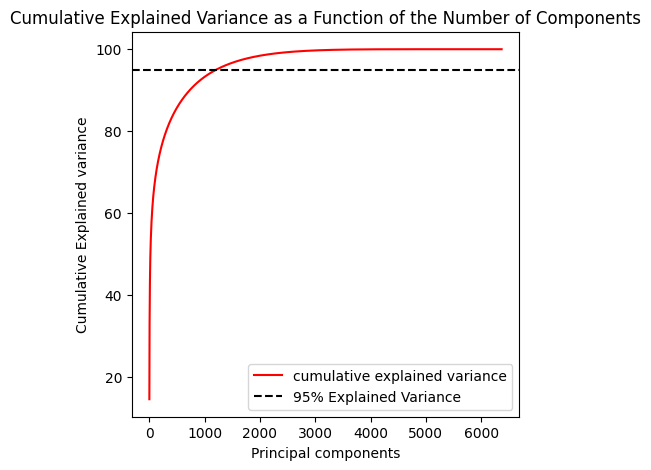

In [21]:
scaler.fit(nonspeech_is13_dataset)
nonspeech_IS13_scaler = scaler.transform(nonspeech_is13_dataset)

plot_relation_between_VAR_and_DIM(nonspeech_IS13_scaler)

nonspeech_IS13_pca = pca_transform(nonspeech_IS13_scaler)

In [22]:
cv_for_nonspeech7k(models_NS, names_NS, nonspeech_IS13_pca, nonspeech_targets)

SVM_Poly:
---------------------------------------------------
|  Class         | Recall         | Precision     |
---------------------------------------------------
| breath/дыхание |  0.910 ± 0.005 | 0.940 ± 0.002 |
| cough/кашель   |  0.407 ± 0.018 | 0.790 ± 0.036 |
| cry/плач       |  0.959 ± 0.008 | 0.487 ± 0.013 |
| laugh/смех     |  0.258 ± 0.021 | 0.855 ± 0.034 |
| scream/крик    |  0.498 ± 0.044 | 0.929 ± 0.011 |
| sneeze/чихание |  0.287 ± 0.015 | 0.714 ± 0.058 |
| yawn/зевание   |  0.226 ± 0.027 | 0.771 ± 0.066 |
---------------------------------------------------
Average Scores   |  0.506 ± 0.020 | 0.784 ± 0.031 |
---------------------------------------------------
Accuracy Score: 0.666 ± 0.011                     |
---------------------------------------------------

SVM_RBF:
---------------------------------------------------
|  Class         | Recall         | Precision     |
---------------------------------------------------
| breath/дыхание |  0.972 ± 0.004 | 0.931 ± 